In [1]:
import matplotlib as mpl
#mpl.rc('font', family='Times New Roman')
mpl.rc('font', family='serif')

import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits

import astropy.units as u
import astropy.time
from astropy.coordinates import (SkyCoord, Distance, Galactic,
                                 EarthLocation, AltAz)
import astropy.coordinates as coord

import pandas as pd

from functools import reduce

In [2]:
from astropy.table import Table
import matplotlib.colors as mcolors
from matplotlib import colors

In [3]:
!pip install requests

In [4]:
# Import cv_coord from Sergey
import requests
# Save datagenerators as file to colab working directory
# If you are using GitHub, make sure you get the "Raw" version of the code
url = 'https://raw.githubusercontent.com/segasai/astrolibpy/master/astrolib/cv_coord.py'
r = requests.get(url)

# make sure your filename is the same as how you want to import
with open('cv_coord.py', 'w') as f:
    f.write(r.text)

# now we can import
import cv_coord as cv_coord


In [5]:
# Import sphere_rotate from Sergey
url = 'https://raw.githubusercontent.com/segasai/astrolibpy/master/my_utils/sphere_rotate.py'
r = requests.get(url)
with open('sphere_rotate.py', 'w') as f:
    f.write(r.text)
import sphere_rotate as sr

In [6]:
# Plotting setup
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize']=10
plt.rcParams['ytick.labelsize']=10

In [7]:
# RG catalog
target_url = 'https://people.ast.cam.ac.uk/~vasily/data/rg_gaia2mass.fits'
hdul = fits.open(target_url)
dg = hdul[1].data
hdul.close()

# RA [0,360]->[-180,180]
ra180=dg['ra']
w = np.where(dg['ra'] > 180)
ra180[w] = dg['ra'][w]-360

In [8]:
# BHB catalog
target_url = 'https://people.ast.cam.ac.uk/~vasily/data/BHB_EDR3_2023_with_mags.fits'
hdul = fits.open(target_url)
bhb = hdul[1].data
hdul.close()

# RA [0,360]->[-180,180]
bhbra180=bhb['ra']
w = np.where(bhb['ra'] > 180)
bhbra180[w] = bhb['ra'][w]-360

In [9]:
# Gaia XP catalog
target_url = 'https://people.ast.cam.ac.uk/~vasily/data/catalogues/gaia_xp_andrae_parallax01.fits'
hdul = fits.open(target_url)
da = hdul[1].data
hdul.close()


In [10]:
# RA, Dec -> Galactic
c=SkyCoord(ra=da['ra']*u.deg, dec=da['dec']*u.deg)
cgal=c.transform_to(Galactic())
dab=np.array(cgal.b/u.deg)

In [11]:
# Extinction
A0 = 3.1*da['ebv']
kg = 0.9761-0.1704*da['bp_rp']
kbp = 1.1517-0.0871*da['bp_rp']
krp = 0.6104-0.0170*da['bp_rp']
ag = kg*A0
abp = kbp*A0
arp = krp*A0
mg = da['PHOT_G_MEAN_MAG']-ag
col = da['bp_rp']-abp+arp

In [12]:
dapm = np.sqrt(da['pmra']**2+da['pmdec']**2)
darpm=mg+5.*np.log10(dapm)-1.47*np.sin(np.abs(dab* np.pi/180.))

In [13]:
# RA [0,360]->[-180,180]
dara180=da['ra']
w = np.where(da['ra'] > 180)
dara180[w] = da['ra'][w]-360

In [14]:
# TARGET 1 = Clean distant red giants from Gaia+2MASS parallax+RPM selection

# Selection cuts
tarx = [-45, 15]
tary = [-20, 0]

rpm_cut=18.
par_cut=0.2
col_cut=1.
mag_lim=18.
dist_cut=50

In [15]:
# Observing region
wxy = np.where((ra180 > tarx[0]) & (ra180 < tarx[1]) & (dg['dec'] > tary[0]) & (dg['dec'] < tary[1]))

In [16]:
wpar=np.where(dg['parallax']<par_cut)
wcol=np.where(dg['col']>col_cut)
wmag=np.where(dg['mg']<mag_lim)
wdist=np.where(dg['dist']>dist_cut)
wrpm=np.where(dg['rpm']<rpm_cut)

wtar1=reduce(np.intersect1d,(wpar,wcol,wmag,wrpm,wdist))
wtar1_xy=np.intersect1d(wtar1,wxy)

print('Total number of distant RGB targets',len(wtar1_xy))

Total number of distant RGB targets 531


(-90.0, 90.0)

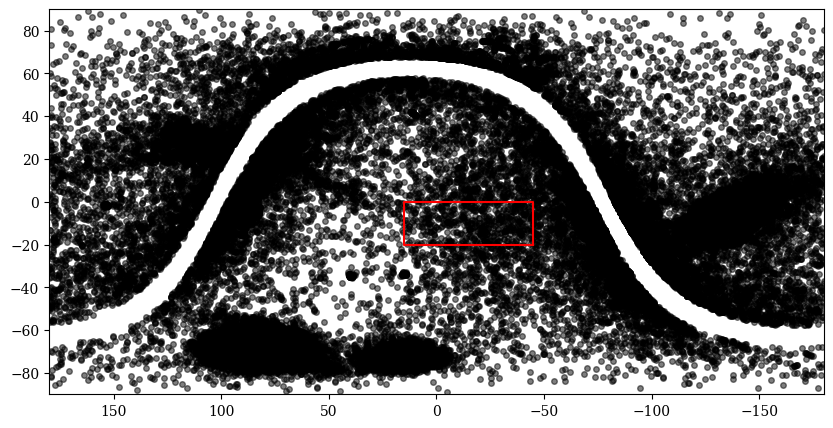

In [17]:
plt.figure(figsize=[10,5])
plt.plot(ra180[wtar1],dg['dec'][wtar1],marker='o',ls='none',color='black',markersize=4,alpha=0.5)
plt.plot([tarx[0],tarx[1],tarx[1],tarx[0],tarx[0]],[tary[0],tary[0],tary[1],tary[1],tary[0]],color='red', linestyle='solid')
plt.xlim(180,-180)
plt.ylim(-90,90)

Total number of relaxed RGB targets 2998


(-90.0, 90.0)

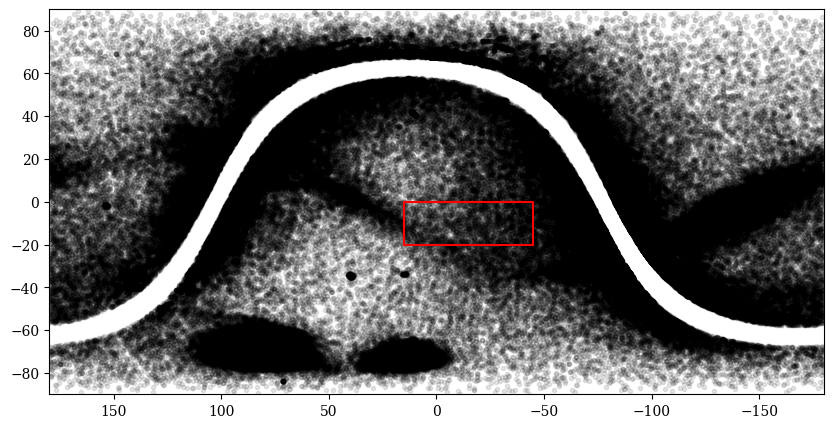

In [18]:
# TARGET 1.2 "relaxed" Gaia+2MASS parallax+RPM RGB selection

# Selection cuts
rpm_cut2=18.5
par_cut2=0.25
col_cut2=1.
mag_lim2=18.5
dist_cut2=30

wpar2=np.where(dg['parallax']<par_cut2)
wcol2=np.where(dg['col']>col_cut2)
wmag2=np.where(dg['mg']<mag_lim2)
wdist2=np.where(dg['dist']>dist_cut2)
wrpm2=np.where(dg['rpm']<rpm_cut2)

wtar12=reduce(np.intersect1d,(wpar2,wcol2,wmag2,wrpm2,wdist2))
wtar12_xy=np.intersect1d(wtar12,wxy)
print('Total number of relaxed RGB targets',len(wtar12_xy))

plt.figure(figsize=[10,5])
plt.plot(ra180[wtar12],dg['dec'][wtar12],marker='o',ls='none',color='black',markersize=3,alpha=0.1)
plt.plot([tarx[0],tarx[1],tarx[1],tarx[0],tarx[0]],[tary[0],tary[0],tary[1],tary[1],tary[0]],color='red', linestyle='solid')
plt.xlim(180,-180)
plt.ylim(-90,90)

In [19]:
phi1,phi2=sr.sphere_rotate(dg['ra'], dg['dec'], 72., -14., 191.10487)

(-40.0, 40.0)

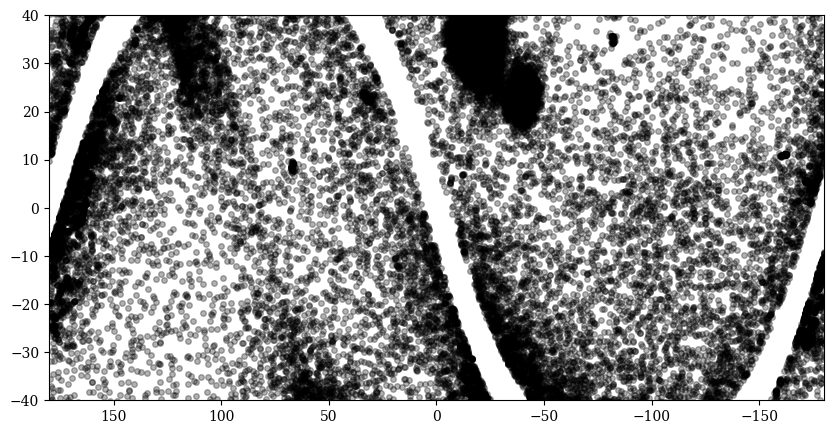

In [20]:
plt.figure(figsize=[10,5])
plt.plot(phi1[wtar1],phi2[wtar1],marker='o',ls='none',color='black',markersize=4,alpha=0.3)
plt.xlim(180,-180)
plt.ylim(-40,40)

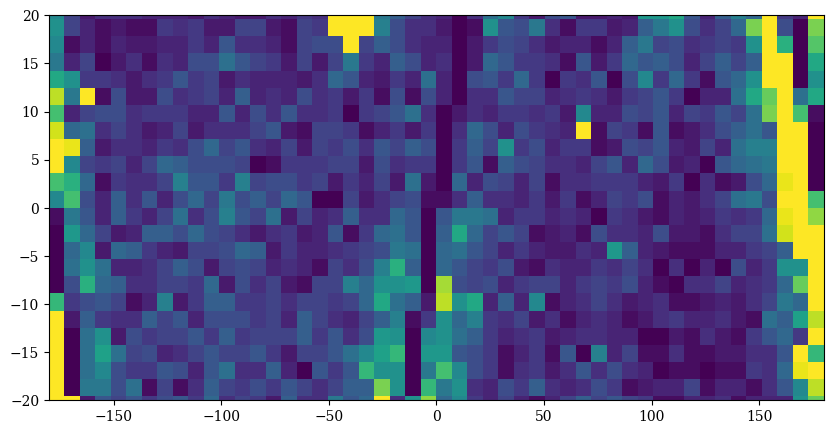

In [21]:
plt.figure(figsize=[10,5])
plt.hist2d(phi1[wtar1], phi2[wtar1], bins=[50,100],vmax=30)#,norm=colors.LogNorm())
plt.ylim(-20,20)
plt.show()

Total number of distant BHB targets 1402


(-90.0, 90.0)

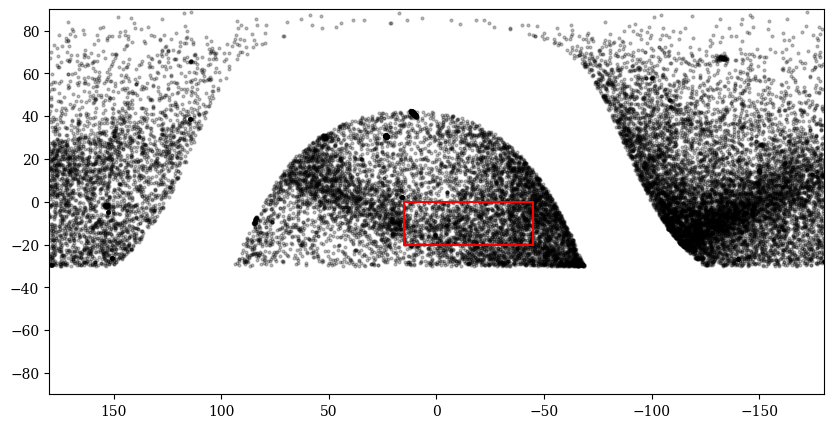

In [22]:
# TARGET 2 = BHBs with distances above some limit
wbhb_dist=np.where(bhb['ps1g']>18.)
wtar2=wbhb_dist

# Observing region
wbhb_xy = np.where((bhbra180 > tarx[0]) & (bhbra180 < tarx[1]) & (bhb['dec'] > tary[0]) & (bhb['dec'] < tary[1]))
wtar2_xy=np.intersect1d(wtar2,wbhb_xy)
print('Total number of distant BHB targets',len(wtar2_xy))

plt.figure(figsize=[10,5])
plt.plot(bhbra180[wtar2],bhb['dec'][wtar2],marker='o',ls='none',color='black',markersize=2,alpha=0.25)
plt.plot([tarx[0],tarx[1],tarx[1],tarx[0],tarx[0]],[tary[0],tary[0],tary[1],tary[1],tary[0]],color='red', linestyle='solid')
plt.xlim(180,-180)
plt.ylim(-90,90)

Total number of XP RGB targets 969


(-90.0, 90.0)

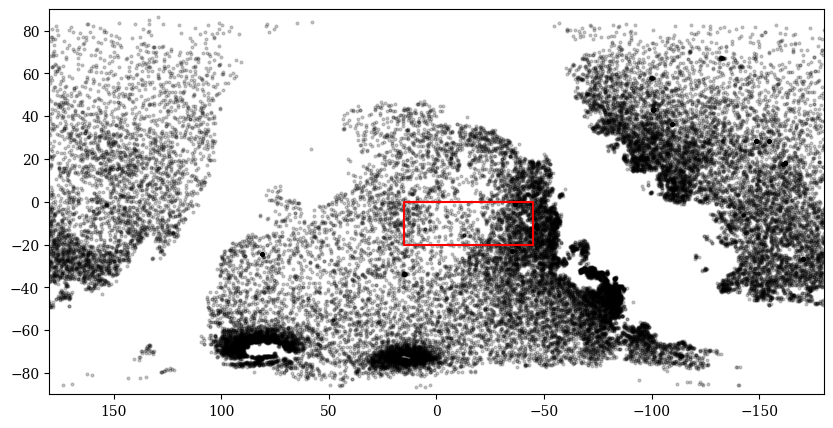

In [23]:
# TARGET 3 = Gaia XP giants
wxpebv=np.where(da['ebv']<0.1)
wlogg=np.where(da['logg']<2.)
wteff=np.where(da['TEFF']<5000)
wmh=np.where(da['mh']<-1.5)
wxpdist=np.where(da['r_med_photogeo']>10e+3)
wxpdist=np.where(da['phot_g_mean_mag']<17.)
wdarpm=np.where(darpm<17)

wtar3=reduce(np.intersect1d,(wlogg,wteff,wmh,wxpdist,wxpebv))

# Observing region
wda_xy = np.where((dara180 > tarx[0]) & (dara180 < tarx[1]) & (da['dec'] > tary[0]) & (da['dec'] < tary[1]))
wtar3_xy=np.intersect1d(wtar3,wda_xy)
print('Total number of XP RGB targets', len(wtar3_xy))

plt.figure(figsize=[10,5])
plt.plot(dara180[wtar3],da['dec'][wtar3],marker='o',ls='none',color='black',markersize=2,alpha=0.2)
plt.plot([tarx[0],tarx[1],tarx[1],tarx[0],tarx[0]],[tary[0],tary[0],tary[1],tary[1],tary[0]],color='red', linestyle='solid')
plt.xlim(180,-180)
plt.ylim(-90,90)


(-20.0, 0.0)

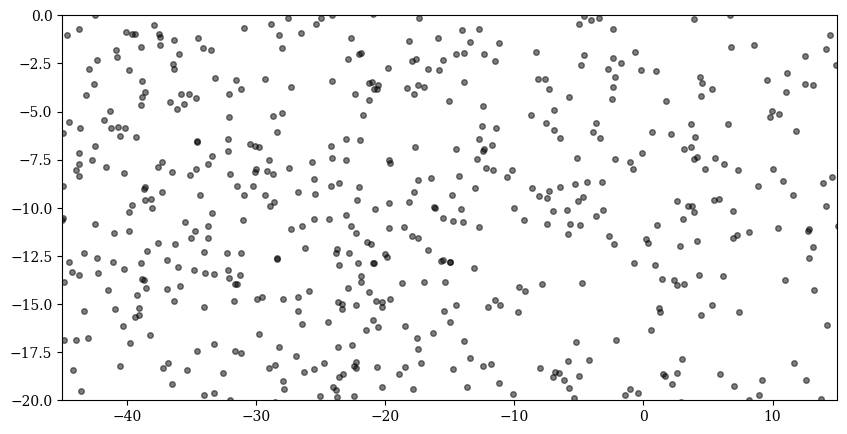

In [24]:
# Zoom-in on high priority RGBs

plt.figure(figsize=[10,5])
plt.plot(ra180[wtar1],dg['dec'][wtar1],marker='o',ls='none',color='black',markersize=4,alpha=0.5)
plt.xlim(tarx)
plt.ylim(tary)

(-20.0, 0.0)

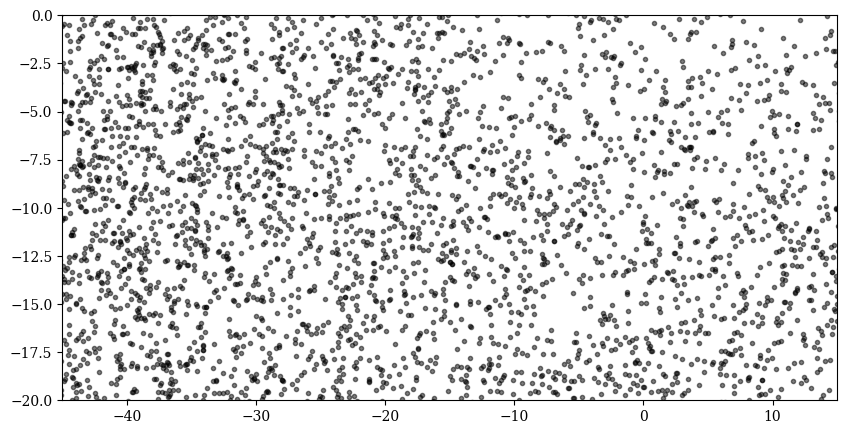

In [25]:
# Zoom-in on relaxed Gaia+2MASS RGBs
plt.figure(figsize=[10,5])
plt.plot(ra180[wtar12],dg['dec'][wtar12],marker='o',ls='none',color='black',markersize=3,alpha=0.5)
plt.xlim(tarx)
plt.ylim(tary)

(-20.0, 0.0)

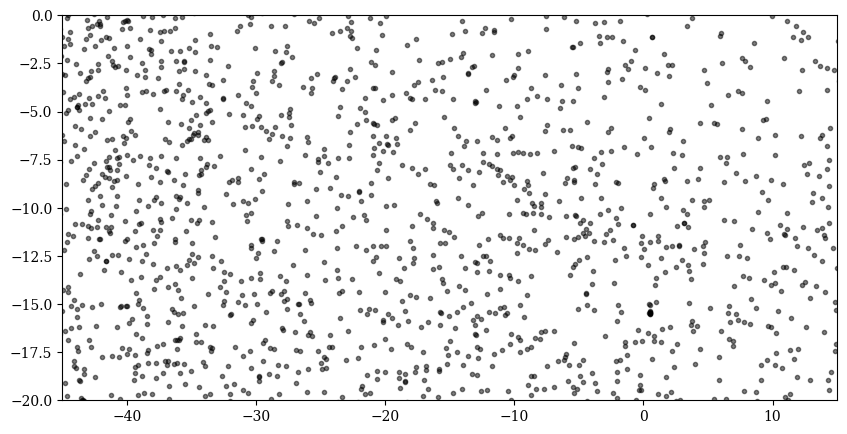

In [26]:
plt.figure(figsize=[10,5])
plt.plot(bhbra180[wtar2],bhb['dec'][wtar2],marker='o',ls='none',color='black',markersize=3,alpha=0.5)
plt.xlim(tarx)
plt.ylim(tary)

In [27]:
# a = [1,2,3,4]
# b = [8,7,9,2,1]
# diff = (set(a) | set(b)) - (set(a) & set(b))
# keep_setb=set(b)-(set(a)&set(b))

In [28]:
# Find the subset of "relaxed RGB" targets that are not included in high priority clean RGBs
keep_wtar12_xy=pd.DataFrame(set(wtar12_xy)-(set(wtar1_xy)&set(wtar12_xy)))
keep_wtar12_xy=np.squeeze(keep_wtar12_xy)

# print(len(set(wtar1_xy)&set(wtar12_xy)))
# print(len((wtar12_xy)))
# print(len(keep_wtar12_xy))

In [29]:
# Number of targets in each category
ntar1=len(wtar1_xy)
ntar12=len(keep_wtar12_xy)
ntar2=len(wtar2_xy)

In [30]:
# PACK Target 1
rev_cur=np.full(shape=ntar1, fill_value=3, dtype=np.int64)
ps1_cur=np.full(shape=ntar1, fill_value=0, dtype=np.int64)
pri_cur=np.full(shape=ntar1, fill_value=10, dtype=np.int64)
dtar1=np.rec.fromarrays([dg['source_id'][wtar1_xy],dg['ra'][wtar1_xy], dg['dec'][wtar1_xy], rev_cur, ps1_cur, pri_cur], names=['SOURCE_ID', 'RA', 'DEC', 'GAIA_REV_ID', 'PS1_ID', 'PRIORITY'])

In [31]:
# PACK Target 12
rev_cur=np.full(shape=ntar12, fill_value=3, dtype=np.int64)
ps1_cur=np.full(shape=ntar12, fill_value=0, dtype=np.int64)
pri_cur=np.full(shape=ntar12, fill_value=9, dtype=np.int64)
dtar12=np.rec.fromarrays([dg['source_id'][keep_wtar12_xy],dg['ra'][keep_wtar12_xy], dg['dec'][keep_wtar12_xy], rev_cur, ps1_cur, pri_cur], names=['SOURCE_ID', 'RA', 'DEC', 'GAIA_REV_ID', 'PS1_ID', 'PRIORITY'])

In [32]:
# PACK Target 2
rev_cur=np.full(shape=ntar2, fill_value=3, dtype=np.int64)
ps1_cur=np.full(shape=ntar2, fill_value=0, dtype=np.int64)
pri_cur=np.full(shape=ntar2, fill_value=8, dtype=np.int64)
dtar2=np.rec.fromarrays([bhb['source_id'][wtar2_xy],bhb['ra'][wtar2_xy], bhb['dec'][wtar2_xy], rev_cur, ps1_cur, pri_cur], names=['SOURCE_ID', 'RA', 'DEC', 'GAIA_REV_ID', 'PS1_ID', 'PRIORITY'])

In [33]:
# Concatenate all targets
data=np.concatenate((dtar1,dtar12))
data=np.concatenate((data,dtar2))


In [ ]:
# Create table, write to FITS
date='021023'
filename='Pisces_'+date+'.fits'
#t = Table(data, copy=False)
#t.write(filename,overwrite=True)
# Add keywords
#fits.setval(filename, 'VERSION', value=date)

In [34]:
print('Total number of targets ',ntar1+ntar12+ntar2)

Total number of targets  4400


In [41]:
# Target summary (spherical area + expected per-pointing), using ONLY what the notebook already defined.


# ---- pull from existing notebook state ----
# Required arrays/indices expected from earlier cells:
#  dg, bhb, ra180, bhbra180, tarx, tary,
#  wtar1, wtar12, wtar2, wtar1_xy, wtar12_xy, wtar2_xy
missing = [name for name in [
    "dg","bhb","ra180","bhbra180","tarx","tary",
    "wtar1","wtar12","wtar2","wtar1_xy","wtar12_xy","wtar2_xy"
] if name not in globals()]
if missing:
    raise RuntimeError(f"Missing required variables from earlier cells: {missing}")

# Default priorities & selection parameters (use existing values if present)
priority_clean   = globals().get("priority_clean", 10)
priority_relaxed = globals().get("priority_relaxed", 9)
priority_bhb     = globals().get("priority_bhb", 8)

par_cut   = globals().get("par_cut",   None)
rpm_cut   = globals().get("rpm_cut",   None)
col_cut   = globals().get("col_cut",   None)
mag_lim   = globals().get("mag_lim",   None)
dist_cut  = globals().get("dist_cut",  None)

par_cut2  = globals().get("par_cut2",  None)
rpm_cut2  = globals().get("rpm_cut2",  None)
col_cut2  = globals().get("col_cut2",  None)
mag_lim2  = globals().get("mag_lim2",  None)
dist_cut2 = globals().get("dist_cut2", None)

bhb_mag_cut = globals().get("bhb_mag_cut", 18.0)  # PS1 g cut used earlier

# Additional-relaxed set (use precomputed keep_wtar12_xy if present; else compute)
if "keep_wtar12_xy" in globals():
    keep_wtar12_xy = globals()["keep_wtar12_xy"]
else:
    keep_wtar12_xy = np.setdiff1d(wtar12_xy, wtar1_xy, assume_unique=False)

# Also compute global "additional relaxed" if needed
relaxed_global_add = np.setdiff1d(wtar12, wtar1, assume_unique=False)

# ---- spherical areas ----
ra1_deg, ra2_deg = float(tarx[0]), float(tarx[1])
dec1_deg, dec2_deg = float(tary[0]), float(tary[1])

ra1 = np.deg2rad(ra1_deg); ra2 = np.deg2rad(ra2_deg)
dec1 = np.deg2rad(dec1_deg); dec2 = np.deg2rad(dec2_deg)

# handle RA wrap robustly
delta_ra = (ra2 - ra1) % (2*np.pi)
survey_area_sr   = delta_ra * (np.sin(dec2) - np.sin(dec1))
survey_area_deg2 = survey_area_sr * (180/np.pi)**2  # deg^2

# WEAVE 2°-diameter field (1° radius spherical cap)
r = np.deg2rad(1.0)
pointing_area_sr   = 2*np.pi*(1 - np.cos(r))
pointing_area_deg2 = pointing_area_sr * (180/np.pi)**2  # ≈ 3.141513 deg^2

def per_pointing_expected(n):
    """Expected targets per pointing from surface density within the survey box."""
    return (n / survey_area_deg2) * pointing_area_deg2

# ---- counts ----
n_clean_global = len(wtar1)
n_relaxed_global = len(wtar12)
n_relaxed_global_add = len(relaxed_global_add)
n_bhb_global = len(wtar2[0])

n_clean_field = len(wtar1_xy)
n_relaxed_field_add = len(keep_wtar12_xy)
n_bhb_field = len(wtar2_xy)

total_global = n_clean_global + n_relaxed_global_add + n_bhb_global
total_field  = n_clean_field  + n_relaxed_field_add  + n_bhb_field

# ---- criteria strings from existing cut variables, if available ----
def fmt(x): 
    return ("{:.3g}".format(x) if isinstance(x,(int,float,np.floating)) else str(x)) if x is not None else "—"

crit_clean = f"parallax<{fmt(par_cut)}, RPM<{fmt(rpm_cut)}, (BP−RP)₀>{fmt(col_cut)}, G₀<{fmt(mag_lim)}, dist>{fmt(dist_cut)} kpc"
crit_relaxed = f"parallax<{fmt(par_cut2)}, RPM<{fmt(rpm_cut2)}, (BP−RP)₀>{fmt(col_cut2)}, G₀<{fmt(mag_lim2)}, dist>{fmt(dist_cut2)} kpc"
crit_bhb = f"PS1 g>{fmt(bhb_mag_cut)} (distance proxy)"

# ---- summary table ----
rows = [
    {"TARGET CATEGORY":"Clean RGB",
     "PRIORITY":priority_clean,
     "GLOBAL":n_clean_global,
     "IN FIELD":n_clean_field,
     "PER POINTING (exp.)":per_pointing_expected(n_clean_field),
     "SELECTION CRITERIA":crit_clean},
    {"TARGET CATEGORY":"Additional Relaxed RGB",
     "PRIORITY":priority_relaxed,
     "GLOBAL":n_relaxed_global_add,
     "IN FIELD":n_relaxed_field_add,
     "PER POINTING (exp.)":per_pointing_expected(n_relaxed_field_add),
     "SELECTION CRITERIA":crit_relaxed},
    {"TARGET CATEGORY":"Blue Horizontal Branch",
     "PRIORITY":priority_bhb,
     "GLOBAL":n_bhb_global,
     "IN FIELD":n_bhb_field,
     "PER POINTING (exp.)":per_pointing_expected(n_bhb_field),
     "SELECTION CRITERIA":crit_bhb},
    {"TARGET CATEGORY":"TOTAL",
     "PRIORITY":"-",
     "GLOBAL":total_global,
     "IN FIELD":total_field,
     "PER POINTING (exp.)":per_pointing_expected(total_field),
     "SELECTION CRITERIA":"Combined selection"},
]

df = pd.DataFrame(rows)
df["PER POINTING (exp.)"] = df["PER POINTING (exp.)"].map(lambda x: f"{x:.1f}")

# Optional efficiencies (fraction of each GLOBAL sample inside the survey box)
clean_eff = (n_clean_field / n_clean_global * 100) if n_clean_global>0 else np.nan
relaxed_eff_full = (len(wtar12_xy) / n_relaxed_global * 100) if n_relaxed_global>0 else np.nan
bhb_eff = (n_bhb_field / n_bhb_global * 100) if n_bhb_global>0 else np.nan
overall_eff = (total_field / total_global * 100) if total_global>0 else np.nan

# Optional: use existing n_pointings if defined for coverage info; else default 35
n_pointings = globals().get("n_pointings", 35)
coverage_deg2 = n_pointings * pointing_area_deg2
coverage_frac = coverage_deg2 / survey_area_deg2 if survey_area_deg2>0 else np.nan

# ---- print ----
print("="*96)
print("WEAVE PISCES TARGET SELECTION — SUMMARY")
print("="*96)
print(f"Survey box:     RA=[{ra1_deg:.1f}, {ra2_deg:.1f}] deg, Dec=[{dec1_deg:.1f}, {dec2_deg:.1f}] deg")
print(f"Survey area:    {survey_area_deg2:.2f} deg²  (spherical)")
print(f"WEAVE FoV:      {pointing_area_deg2:.5f} deg² (2° diameter)")
print(f"Requested:      {n_pointings} pointings → {coverage_deg2:.1f} deg² ({coverage_frac*100:.1f}% of survey)")
print("-"*96)
print(df.to_string(index=False))
print("-"*96)
print("EFFICIENCY (fraction of global sample inside the survey box)")
print(f"  Clean RGB:   {clean_eff:.1f}%")
print(f"  Relaxed RGB: {relaxed_eff_full:.1f}%  (uses full relaxed; 'additional only' uses set difference)")
print(f"  BHB:         {bhb_eff:.1f}%")
print(f"  Overall:     {overall_eff:.1f}%")

WEAVE PISCES TARGET SELECTION — SUMMARY
Survey box:     RA=[-45.0, 15.0] deg, Dec=[-20.0, 0.0] deg
Survey area:    1175.78 deg²  (spherical)
WEAVE FoV:      3.14151 deg² (2° diameter)
Requested:      35 pointings → 110.0 deg² (9.4% of survey)
------------------------------------------------------------------------------------------------
       TARGET CATEGORY PRIORITY  GLOBAL  IN FIELD PER POINTING (exp.)                                        SELECTION CRITERIA
             Clean RGB       10  247149       531                 1.4      parallax<0.2, RPM<18, (BP−RP)₀>1, G₀<18, dist>50 kpc
Additional Relaxed RGB        9  474097      2467                 6.6 parallax<0.25, RPM<18.5, (BP−RP)₀>1, G₀<18.5, dist>30 kpc
Blue Horizontal Branch        8   23711      1402                 3.7                                 PS1 g>18 (distance proxy)
                 TOTAL        -  744957      4400                11.8                                        Combined selection
--------------------

In [40]:
print(len(wtar2))

1
